# BenzDB tools

## Source code

### Module imports

In [1]:
import ipywidgets as w
import requests
import json
import base64 
import io
from PIL import Image
import IPython as ip
import jupyter_jsmol as Jsmol
import pandas as pd
import matplotlib.pyplot as plt

### Definition of criterion classes

#### Definition of the main criterion class

In [2]:
class Criterion:
    """ This class allows for representing criterions """
    
    def __init__ (self, key: str, description: str):
        """ initializes the criterion """
        self.__key = key
        self.__description  = description     
    
    
    def display (self):
        """ displays the widget corresponding to the criterion """
        pass
    
    
    def get_criterion (self) -> str:
        """ returns the JSON string corresponding to the criterion, an empty string if the criterion is not set """
        pass
    
    
    def get_description (self) -> str:
        """ returns the description """
        return self.__description
    
    def get_key (self) -> str:
        """ returns the key related to the criterion """
        return self.__key

#### Definition of criterion child classes

In [3]:
class Int_Criterion (Criterion):
    """ This class allows for representing criterions based on int value """
 
    def __init__ (self, key: str, description: str, initial_value: int):
        """ initializes the criterion """
        super().__init__(key, description)
        
        self.__element =  w.IntText(value=1, layout={"width": "auto"})
        self.__condition = w.Select(description=self.get_description(), options=["not set","=","<>","<=","<",">",">="], value='not set', rows=1, layout={"width": "auto"})
                
        box = w.HBox([self.__condition, self.__element])
        display(box)
        
    
    def get_criterion (self) -> str:
        """ returns the JSON string corresponding to the criterion, an empty string if the criterion is not set """
        if self.__condition.value == "not set":
            return ""
        else:
            return '"' + self.get_key() + '": "' + self.__condition.value + " " + str(self.__element.value) + '"'

In [4]:
class Float_Criterion (Criterion):
    """ This class allows for representing criterions based on float value """
 
    def __init__ (self, key: str, description: str, initial_value: float):
        """ initializes the criterion """
        super().__init__(key, description)
        
        self.__element =  w.IntText(layout={"width": "auto"})
        self.__condition = w.Select(description=self.get_description(), options=["not set","=","<>","<=","<",">",">="], value='not set', rows=1, layout={"width": "auto"})
                
        box = w.HBox([self.__condition, self.__element])
        display(box)
        
    
    def get_criterion (self) -> str:
        """ returns the JSON string corresponding to the criterion, an empty string if the criterion is not set """
        if self.__condition.value == "not set":
            return ""
        else:
            return '"' + self.get_key() + '": "' + self.__condition.value + " " + str(self.__element.value) + '"'

In [5]:
class String_Criterion (Criterion):
    """ This class allows for representing criterions based on string value """
 
    def __init__ (self, key: str, description: str, initial_value: int):
        """ initializes the criterion """
        super().__init__(key, description)
        
        self.__element =  w.IntText(value=1, layout={"width": "auto"})
        self.__condition = w.Select(description=self.get_description(), options=["not set","=","<>"], value='not set', rows=1, layout={"width": "auto"})
                
        box = w.HBox([self.__condition, self.__element])
        display(box)
        
    
    def get_criterion (self) -> str:
        """ returns the JSON string corresponding to the criterion, an empty string if the criterion is not set """
        if self.__condition.value == "not set":
            return ""
        else:
            return '"' + self.get_key() + '": "' + self.__condition.value + " " + str(self.__element.value) + '"'

In [6]:
class Query_Criterion (Criterion):
    """ This class allows for representing the desired query """
 
    def __init__ (self, key: str, description: str):
        """ initializes the criterion """
        super().__init__(key, description)
        
        self.__element =  w.Select(description=self.get_description(), options=["benzenoids","ir","ims2d1a","nics","clar_covers","properties","irregularities"], value='benzenoids', rows=1, layout={"width": "auto"})
                
        box = w.HBox([self.__element])
        display(box)
        
    
    def get_criterion (self) -> str:
        """ returns the JSON string corresponding to the criterion, an empty string if the criterion is not set """
        return str(self.__element.value)

### Definition of the form class

In [7]:
class Form:
    
    def __init__ (self):
        """ initialise the form """
        self.__query = None         # the query
        self.__demand_type = None   # the type of demand
        self.__json_string = None   # the query as a JSON string
        self.__data = None          # the data related to the query (if the query succeeds)
        
        self.create_form()
        
        
    def create_form(self) -> None:
        """ creates the form allowing for choosing the values of desired criteria """
        self.__criteria = []

        # criteria about basic information
        self.__criteria.append (Int_Criterion(key="nbHexagons", description="# hexagons", initial_value=1))
        self.__criteria.append (Int_Criterion(key="nbCarbons", description="# carbons", initial_value=1))
        self.__criteria.append (Int_Criterion(key="nbHydrogens", description="# hydrogens", initial_value=1))

        # query
        self.__criteria.append (Query_Criterion(key="query", description="query"))    

        # validation buttons
        count_btn = w.Button (description="Count")
        count_btn.on_click (self.perform_query)

        getdata_btn = w.Button (description="Get Data")
        getdata_btn.on_click (self.perform_query)

        getquery_btn = w.Button (description="Get JSON Query")
        getquery_btn.on_click (self.perform_query)
        
        box = w.HBox([count_btn, getdata_btn,getquery_btn])
        display(box)
    
    
    def perform_query (self, btn) -> None:
        """ performs the query and sets the corresponding attributes """ 
        # we identify the type of demand
        if btn.description == "Count":
            self.__demand_type = "count"
        elif btn.description == "Get Data":
            self.__demand_type = "data"
        elif btn.description == "Get JSON Query":
            self.__demand_type = "json"
        else:
            self.__demand_type = "unknown"

        # we build the JSON string and the corres
        self.__json_string = "{\n"
        for c in self.__criteria:
            if isinstance(c,Query_Criterion):
                self.__query = c.get_criterion()
            else:
                s = c.get_criterion()
                if len(s) > 0:
                    if len(self.__json_string) > 3:
                        self.__json_string += ",\n"
                    self.__json_string += "\t" + s
        self.__json_string += "\n}"

        if self.__demand_type == "data":
            response = requests.post("https://benzenoids.lis-lab.fr/find_"+self.__query, json= json.loads(self.__json_string))
        elif self.__demand_type == "count":
            response = requests.post("https://benzenoids.lis-lab.fr/count_"+self.__query, json= json.loads(self.__json_string))
        
        if self.__demand_type in ["data","count"]:
            if response.status_code == 200:
                self.__data = response.json()

        
    def get_data (self):
        """ returns the data related to the query """
        return self.__data
    
    
    def get_query (self):
        """ returns the desired query """
        return self.__query

    
    def get_json_string (self):
        """ returns the JSON string related to the desired query """
        return self.__json_string
    

    def get_demand_type (self):
        """ returns the type of the current demand """
        return self.__demand_type

### Definition of the display classes

In [8]:
class Display:
    """ This class allows for displaying benzenoid information """
    
    def __init__ (self, info: dict):
        """ initializes the display tool """
        self.__information = info
        self.__df = pd.DataFrame()
        
    
    def display (self) -> None:
        """ displays the information """
        self.__df["Benzenoid id"] = self.get_information("idBenzenoid")
        self.__df["InChI"] = self.get_information("inchi")
        self.__df.style\
            .format(precision=5, thousands=",", decimal=".") \
            .format_index(str.upper, axis=1) 
           # .relabel_index(["row 1", "row 2"], axis=0)
        
        print ("Benzenoid #",self.get_information("idBenzenoid"), sep="")
        print ("InChI:",self.get_information("inchi"))
        print ("Label:",self.get_information("label"))
        print ("#hexagons:",self.get_information("nbHexagons"))
        print ("#carbons:",self.get_information("nbCarbons"))
        print ("#hydrogens:",self.get_information("nbHydrogens"))
        print ("Weight:",self.get_information("weight"))
        print ("Irregularity:",self.get_information("irregularity"))
        self.display_molecule()
    
    
    def display_molecule (self) -> None:
        """ displays the molecule thanks to Jsmol """
        view = Jsmol.JsmolView.from_str(str(self.get_information("nbCarbons")+self.get_information("nbHydrogens"))+"\nComment\n"+self.get_information("geometry"))
        ip.display.display(view)
        
    
    def display_image (self, str64: str) -> None:
        """ displays the base-64 image defined by str64 """
        img = Image.open(io.BytesIO(base64.b64decode(str64)))
        ip.display.display(img)
        
    
    def get_information (self, key) -> dict:
        """ returns the information """
        return self.__information[key]
    
    
    def get_data_frame (self) -> pd.DataFrame:
        """ returns the data frame containing the information about the molecule """
        return self.__df.transpose()

In [19]:
class Display_IR (Display):
    """ This class allows for displaying benzenoid information from IR query """
    
    def display (self) -> None:
        """ displays the information """
        super().display()
        print("Final energy:",self.get_information("finalEnergy"))
        print("Frequencies:",self.get_information("frequencies")) 
        print("Intensities:",self.get_information("intensities"))
        # print("AMES Format:",self.get_information("amesFormat"))
        
        x = [float(v) for v in self.get_information("frequencies").split(" ")]
        y = [float(v) for v in self.get_information("intensities").split(" ")]
        
        plt.cla()
        plt.plot(x, y)
        plt.xlabel('frequencies')
        plt.ylabel('intensities')
        plt.show()


In [10]:
class Display_IMS2D1A (Display):
    """ This class allows for displaying benzenoid information from IMS2D1A query """
    
    def display (self) -> None:
        """ displays the information """
        super().display()
        print ("Type:",self.get_information("type"))
        self.display_image(self.get_information("picture"))

In [11]:
class Display_NICS (Display):
    """ This class allows for displaying benzenoid information from NICS query """
    
    def display (self) -> None:
        """ displays the information """
        super().display()
        print ("NICS values:", self.get_information("nics"))

In [12]:
class Display_Clar_Covers (Display):
    """ This class allows for displaying benzenoid information from Clar Cover query """
    
    def display (self) -> None:
        """ displays the information """
        super().display()
        self.display_image(self.get_information("clarCover"))

In [13]:
class Display_Properties (Display):
    """ This class allows for displaying benzenoid information from properties query """
    
    def display (self) -> None:
        """ displays the information """
        super().display()
        yesno = ["no","yes"]
        print ("Catacondensed:",yesno[self.get_information("catacondensed")])
        print ("Coronoid:",yesno[self.get_information("coronoid")])
        print ("Coronenoid:",yesno[self.get_information("coronenoid")])
        print ("Symmetry:",self.get_information("symmetry"))
        print ("#Kekulé structures:",self.get_information("kekule"))
        print ("HOMO:",self.get_information("homo"))
        print ("LUMO:",self.get_information("lumo"))
        print ("Dipole moment:",self.get_information("moment"))

In [14]:
class Display_Irregularities (Display):
    """ This class allows for displaying benzenoid information from irregularities query """
    
    def display (self) -> None:
        """ displays the information """
        super().display()
        'solo', 'duo', 'trio', 'quartet'
        print ("# solo:",self.get_information("solo"))
        print ("# duo:",self.get_information("duo"))
        print ("# trio:",self.get_information("trio"))
        print ("# quartet:",self.get_information("quartet"))
        

## Filling the form

In [15]:
form = Form()


## Processing the result molecule per molecule

Benzenoid #3532
InChI: 1S/C14H10/c1-3-7-13-11(5-1)9-10-12-6-2-4-8-14(12)13/h1-10H
Label: 1-3-4
#hexagons: 3
#carbons: 14
#hydrogens: 10
Weight: 178.22976
Irregularity: 0.8


JsmolView(layout=Layout(align_self='stretch', height='400px'))

Final energy: -539.418871
Frequencies: 99 104 236 250 252 409 419 447 455 518 518 559 570 612 649 735 741 743 767 787 820 851 861 903 903 907 971 984 1006 1022 1023 1035 1078 1080 1136 1193 1209 1221 1227 1255 1274 1300 1337 1353 1400 1405 1477 1479 1501 1520 1560 1586 1624 1663 1675 1681 3184 3187 3187 3197 3199 3207 3213 3218 3225 3235
Intensities: 0.0 0.661 2.943 0.0 0.3893 0.0 0.4113 5.568 1.754 0.779 3.93 0.0 0.3429 0.0 4.626 0.0602 2.394 2.29 77.75 0.0 0.0 64.42 0.0462 0.0 1.454 12.29 0.0 5.315 0.0 0.0696 0.0 1.375 0.7198 4.306 1.119 1.451 0.1993 0.0792 0.6459 2.117 1.035 10.07 0.0356 1.441 0.0931 2.026 0.5932 1.176 3.484 14.22 7.208 1.743 0.0105 4.421 0.5221 0.4501 0.4279 4.862 2.655 0.0777 19.87 42.12 45.52 3.508 38.73 31.87
AMES Format: <?xml version="1.0" encoding="UTF-8"?>
<pahdatabase xmlns="https://benzenoids.lis-lab.fr/" database="theoretical" version="1.1" date="2024-06-05" full="false">
  <comment>This file is produced from BenzDB database, version 1.1. See: https://ben

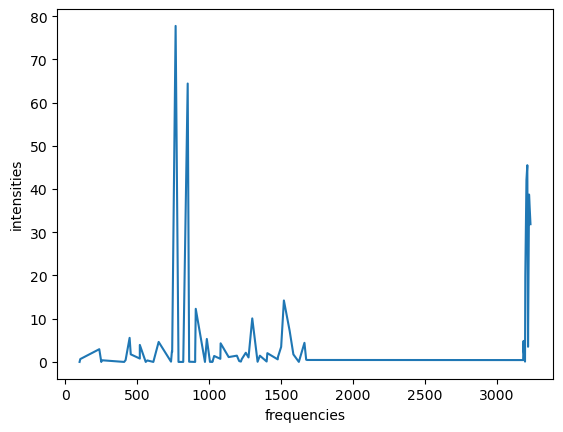

Benzenoid #4421
InChI: 1S/C14H10/c1-2-6-12-10-14-8-4-3-7-13(14)9-11(12)5-1/h1-10H
Label: 0-4-8
#hexagons: 3
#carbons: 14
#hydrogens: 10
Weight: 178.22976
Irregularity: 0.8


JsmolView(layout=Layout(align_self='stretch', height='400px'))

Final energy: -539.410374
Frequencies: 94 126 240 243 277 394 404 405 491 495 519 548 604 635 660 675 760 773 773 791 796 829 869 891 919 940 947 951 989 996 1024 1026 1043 1047 1144 1200 1206 1217 1226 1249 1319 1324 1332 1362 1404 1448 1450 1451 1513 1514 1543 1600 1610 1643 1689 1689 3181 3183 3185 3186 3190 3191 3206 3206 3221 3222
Intensities: 1.045 0.0 1.304 0.0 0.0 0.0753 0.0 0.0 17.83 0.0 0.0 0.0 0.0 7.543 0.0 0.5352 79.39 0.0 0.0 0.0 0.0 0.0083 0.0 0.0 70.57 1.645 0.0 0.0 0.0 10.84 0.0 0.0 3.873 0.0 0.0 5.317 2.681 2.095 0.0 0.0 0.0 9.735 0.0 2.344 3.959 0.2108 0.0 0.0 3.519 2.129 0.0 5.468 0.0 0.0 0.0 7.282 10.01 0.0 0.0 17.51 0.0016 0.0 0.0 78.32 90.18 0.0
AMES Format: <?xml version="1.0" encoding="UTF-8"?>
<pahdatabase xmlns="https://benzenoids.lis-lab.fr/" database="theoretical" version="1.1" date="2024-06-05" full="false">
  <comment>This file is produced from BenzDB database, version 1.1. See: https://benzenoids.lis-lab.fr/</comment>
  <species>
    <specie uid="4421">
 

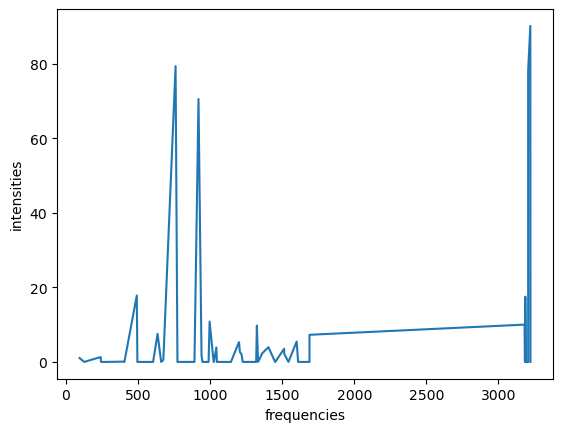

Benzenoid #4674
InChI: 1S/C13H22/c1-4-10-6-2-8-12-9-3-7-11(5-1)13(10)12/h10-13H,1-9H2
Label: 0-3-4
#hexagons: 3
#carbons: 13
#hydrogens: 9
Weight: 165.21108
Irregularity: 1.0


JsmolView(layout=Layout(align_self='stretch', height='400px'))

Final energy: -500.698725
Frequencies: 167 216 293 439 439 491 498 501 602 629 658 776 784 804 851 851 870 876 917 997 1008 1072 1072 1134 1150 1207 1235 1235 1248 1287 1287 1378 1378 1437 1449 1480 1525 1569 1596 1596 1610 1610 3188 3188 3189 3197 3200 3200 3216 3216 3218
Intensities: 0.0 7.185 0.0 1.472 1.472 0.2879 1.251 0.0 0.0 0.0 0.0 0.0 92.14 0.0 0.0909 0.0908 67.48 0.0 0.0 0.0 1.318 1.306 1.305 0.0 1.644 0.0 6.02 6.02 0.0 0.9135 0.9134 2.168 2.168 0.0 0.0 0.0494 0.0 0.0 8.2 8.199 5.324 5.322 1.822 1.822 0.0 0.0 23.24 23.25 63.71 63.7 0.0
AMES Format: <?xml version="1.0" encoding="UTF-8"?>
<pahdatabase xmlns="https://benzenoids.lis-lab.fr/" database="theoretical" version="1.1" date="2024-06-05" full="false">
  <comment>This file is produced from BenzDB database, version 1.1. See: https://benzenoids.lis-lab.fr/</comment>
  <species>
    <specie uid="4674">
      <comments>
        <comment type="generic"># b3lyp/6-31g opt freq</comment>
        <comment>1S/C13H22/c1-4-10-6-2-8-12

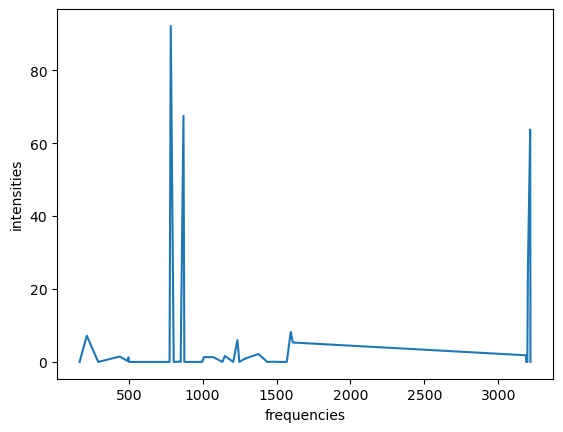

In [20]:
demand_type = form.get_demand_type()

if demand_type == "data":
    data = form.get_data()
    query = form.get_query()
    
    for molecule in data:
        if query == "benzenoids":
            d = Display(molecule)
        elif query == "ir":
            d = Display_IR(molecule)
        elif query == "ims2d1a":
            d = Display_IMS2D1A(molecule)
        elif query == "nics":
            d = Display_NICS(molecule)
        elif query == "clar_covers":
            d = Display_Clar_Covers(molecule)
        elif query == "properties":
            d = Display_Properties(molecule)
        elif query == "irregularities":
            d = Display_Irregularities(molecule)
        d.display()
        
elif demand_type == "count":
    print ("Number of molecules:",form.get_data())
    
elif demand_type == "json":
    print ("JSON query:")
    print (form.get_json_string())

In [17]:
import pandas as pd


df = pd.DataFrame({
    "strings": ["Adam", "Mike"],
    "ints": [1, 3],
    "floats": [1.123, 1000.23]
})
df.style \
  .format(precision=5, thousands=",", decimal=".") \
  .format_index(str.upper, axis=1) \
  .relabel_index(["row 1", "row 2"], axis=0)

df.transpose()

,0,1
strings,Adam,Mike
ints,1,3
floats,1.123,1000.23
